# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues
- Alexandre Gonçalves
- Pedro Costa
- Santiago Taylor
- Lena Hermann

# Notebook 03 - Encoding, Scaling and Feature Selection

## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
&nbsp;&nbsp;&nbsp;[1.1 Import the Needed Libraries](#import_libaries) <br>
&nbsp;&nbsp;&nbsp;[1.2 Load the Data](#load_data) <br>
[2. Encoding Overview](#encoding) <br>
[3. Encoding and Scaling Pipeline](#e_s_pipeline) <br>
[4. Feature Selection Pipeline](#f_pipeline) <br>
&nbsp;&nbsp;&nbsp;[4.1 Correlation](#corr) <br>
&nbsp;&nbsp;&nbsp;[4.2 RFE](#rfe) <br>
&nbsp;&nbsp;&nbsp;[4.3 Random Forest Feature Importance](#rf) <br>
&nbsp;&nbsp;&nbsp;[4.4 Lasso Regression](#lassolr) <br>
&nbsp;&nbsp;&nbsp;[4.5 Chi Squared Test](#chi) <br>
&nbsp;&nbsp;&nbsp;[4.6 Cramer's V](#cramer) <br>
&nbsp;&nbsp;&nbsp;[4.7 Summary](#summary) <br>
[5. Saving files](#save) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the Needed Libraries <a id='import_libaries'></a>

In [5]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

from scipy.stats import uniform, randint

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

# Evaluation
from sklearn.metrics import f1_score

# Lasso
from sklearn.linear_model import LassoCV

# RFE
from sklearn.feature_selection import RFE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set a global seed
np.random.seed(42)

### 1.2 Load the Data <a id='load_data'></a>
[to the top](#top)

In [7]:
import zipfile #to open zipfile
train_zip_path = 'train_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df_raw = read_zipped_csv(train_zip_path)

In [8]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [3]:
# Load the feature datasets
X_train = pd.read_csv("preprocessed_files/prepared_claims_data_train_median.csv")
X_val = pd.read_csv("preprocessed_files/prepared_claims_data_val_median.csv")
X_test = pd.read_csv("preprocessed_files/prepared_claims_data_test_median.csv")
X_test_submission = pd.read_csv("preprocessed_files/prepared_claims_data_test_unseen_median.csv")

# Load the target datasets
y_train = pd.read_csv("preprocessed_files/y_train_encoded_median.csv")
y_val = pd.read_csv("preprocessed_files/y_val_encoded_median.csv")
y_test = pd.read_csv("preprocessed_files/y_test_encoded_median.csv")

# Inspect loaded data
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
print("X_test_submission shape:", X_test_submission.shape, "y_test shape:", y_test.shape)

X_train shape: (346576, 43) y_train shape: (346576, 1)
X_val shape: (91844, 43) y_val shape: (91844, 1)
X_test shape: (114806, 43) y_test shape: (114806, 1)
X_test_submission shape: (387975, 43) y_test shape: (114806, 1)


In [15]:
print(X_train.columns)


Index(['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents',
       'Cause Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Age_Group', 'Wage_Group', 'Carrier Name Grouped',
       'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year',
       'Accident Date_Month', 'Assembly Date_Month', 'Assembly Date_Day',
       'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'Accident_Month_Sin',
       'Accident_Month_Cos', 'Accident_Day', 'Assembly_Year',
       'Assembly_Month_Sin', 'Assembly_Month_Cos', 'C-2_Month_Sin',
       'C-2_Month_Cos', 'Region', 'State'],
      dtype='object')


### 2. Encoding Overview <a id='encoding'></a>
[to the top](#top)

We decide to encode the variables as follows:
- __One-Hot Encoding:__ For variables with a small number of unique values (< 5); preferable because it treats each category independently and avoids introducing an artificial order.
- __Ordinal Encoding:__ For variables with a natural order or numeric-like scale.

| **Variable**                     | **Encoding Type**       | **Reason**                                                                 |
|----------------------------------|-------------------------|-----------------------------------------------------------------------------|
| Age at Injury                    | None                   | Numerical variable; leave as-is.                                           |
| Attorney/Representative          | One-Hot                | Binary categorical (Yes/No).                                               |
| Average Weekly Wage              | None                   | Numerical variable; leave as-is.                                           |
| Carrier Name                     | -                  | High-cardinality categorical; Will only used grouped feature.                          |
| Carrier Type                     | One-Hot                  | Nominal categorical; Label Encoding is efficient for lower cardinality.    |
| Claim Identifier                 | None                   | Unique identifier; leave as-is.                                            |
| County of Injury                 | One-Hot                  | High-cardinality categorical; One-Hot avoids unintended ordinal meaning.   |
| COVID-19 Indicator               | One-Hot                | Binary categorical (Yes/No).                                               |
| District Name                    | One-Hot                   | Categorical variable, moderate cardinality.   |
| Gender                           | One-Hot                | Binary categorical (Male/Female/Other).                                    |
| Industry Code Description        | One-Hot                   | High-cardinality nominal; convert to One-Hot for consistency                    |
| Medical Fee Region               | Ordinal                | Nominal categorical (regions); Consists of order.  |
| WCIO Cause of Injury Code        | -                  | Numerical but nominal. Will only used grouped feature.
| WCIO Nature of Injury Code       | -                  | Numerical but nominal. Will only used grouped feature.                         |
| WCIO Part Of Body Code           | -                  | Numerical but nominal. Will only used grouped feature.                        |
| Zip Code                         | -                  | High-cardinality categorical. Will only use newly created features from it.                |
| Number of Dependents             | None                   | Numerical variable; leave as-is.                                           |
| Lag_Time                         | None                   | Numerical variable; leave as-is.                                           |
| Accident_to_C2_Lag               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Accident Date_Month              | None                | Cyclical data; leave and see if sin/cos transformations work better.                |
| Accident Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly Date_Year               | None                   | Numerical variable; leave as-is.                                           |
| Assembly Date_Month              | None                | Cyclical data; leave and see if sin/cos transformations work better.                |
| Assembly Date_Day                | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2 Date_Year                    | None                   | Numerical variable; leave as-is.                                           |
| C-2 Date_Month                   | None                | Cyclical data; leave and see if sin/cos transformations work better.                |
| C-2 Date_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Accident_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Accident_Month                   | None                | Cyclical data; leave and see if sin/cos transformations work better.                |
| Accident_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Accident_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Assembly_Year                    | None                   | Numerical variable; leave as-is.                                           |
| Assembly_Month                   | None                | Cyclical data; leave and see if sin/cos transformations work better.                |
| Assembly_Month_Sin               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Month_Cos               | None                   | Already processed as cyclical; leave as-is.                                |
| Assembly_Day                     | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| C-2_Year                         | None                   | Numerical variable; leave as-is.                                           |
| C-2_Month                        | None                | Cyclical data; leave and see if sin/cos transformations work better.                |
| C-2_Month_Sin                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Month_Cos                    | None                   | Already processed as cyclical; leave as-is.                                |
| C-2_Day                          | None                   | Numerical; leave as-is unless specific patterns are found.                 |
| Cause Injury Category            | One-Hot                  | Nominal categorical.                          |
| Nature of Injury Category        | One-Hot                  | Nominal categorical.                          |
| Body Part Category               | One-Hot                  | Nominal categorical.                      |
| Age_Group                        | Ordinal                | Categorical with inherent order (e.g., Teen, Adult); Ordinal Encoding fits.|
| Wage_Group                       | Ordinal                | Categorical with inherent order (e.g., Low, Medium, High); Ordinal fits.   |
| Carrier Name Grouped             | One-Hot                  | High-cardinality nominal.                     |
| Region                        | Ordinal                | Categorical with inherent order (distance between region related to numbers); Ordinal Encoding fits.|
| State                       | Ordinal                | Categorical with inherent order (distance between region related to numbers); Ordinal fits.   |


In [16]:
num_features1 = X_train.shape[1]
print(f"Number of features in X_train: {num_features1}")

Number of features in X_train: 42


#### Numerical Features

In [17]:
numerical_features = [
    'Age at Injury', 'Average Weekly Wage', 'Claim Identifier',
    'Number of Dependents', 'Lag_Time', 'Accident_to_C2_Lag',
    'Accident Date_Year', 'Accident Date_Month', 'Accident_Day','Accident_Month_Sin', 'Accident_Month_Cos',
    'Assembly Date_Month', 'Assembly Date_Day','Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos',
    'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'C-2_Month_Sin', 'C-2_Month_Cos'
]


_Drop the following columns because grouped versions were created and otherwise One-Hot Encoding will blow up the data sets_

In [18]:
X_train = X_train.drop(columns=['Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_val = X_val.drop(columns=['Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_test = X_test.drop(columns=['Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])
X_test_submission = X_test_submission.drop(columns=['Carrier Name', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code'])

#### One Hot Encoding

In [19]:
onehot_features = [
    'Attorney/Representative', 'COVID-19 Indicator', 'Gender', 
    'Carrier Type', 'District Name', 'Industry Code Description', 
    'County of Injury', 'Cause Injury Category', 'Nature of Injury Category', 
    'Body Part Category', 'Carrier Name Grouped'
]


In [20]:
# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#### Ordinal Encoding 

In [21]:
# Define ordinal features and categories
state_categories = [str(i) for i in range(100)] + ['other']
ordinal_features = ['Age_Group', 'Wage_Group', 'Medical Fee Region','Region', 'State']  # Add ordinal features if applicable
ordinal_categories = [
    ['Teen', 'Young Adult', 'Adult', 'Middle-Aged Adult', 'Older Adult', 'Senior'],  # Age_Group
    ['Low', 'Below Average', 'Average', 'Above Average', 'High'],  # Wage_Group
    ['I','II', 'III', 'IV', 'UK'], # Medical Fee Region
    ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', 'other'], # Region
    state_categories # States
]

# Initialize and fit OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)



### 3. Encoding and Scaling Pipeline <a id='e_s_pipeline'></a>
[to the top](#top)

Our encoding and scaling pipeline is designed to handle different types of features (numerical, ordinal, and categorical) systematically and consistently. For __categorical variables__, we use __OneHotEncoder__ to convert nominal categories into binary vectors and optionally scale them using __StandardScaler__. __Ordinal features__ are processed with __OrdinalEncoder__ to preserve their inherent order, followed by scaling to ensure consistent treatment across the pipeline. __Numerical features__ are scaled directly using __StandardScaler__, bringing all numerical values to a standard scale with a mean of 0 and a standard deviation of 1. By combining these transformations into a single __ColumnTransformer__, we ensure that the feature processing is unified, reproducible, and easily applicable to all datasets (training, validation, and test).

We also tested different settings using MinMax Scaler and Robost Scaler. The results can be found in the final report.

In [22]:
# Define transformations
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('scaler', StandardScaler())  # Change Scaler based on version to test
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())  # Change Scaler based on version to test
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Change Scaler based on version to test
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('num', numerical_transformer, numerical_features)  # Ensure numerical features are also scaled
])

# Apply the preprocessor: fit on training data and transform all datasets
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)
X_test_submission_transformed = preprocessor.transform(X_test_submission)

# Save the preprocessor for future use
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

print("Validated feature groups:")
print("One-hot features:", onehot_features)
print("Numerical features:", numerical_features)
print("Ordinal features:", ordinal_features)

Validated feature groups:
One-hot features: ['Attorney/Representative', 'COVID-19 Indicator', 'Gender', 'Carrier Type', 'District Name', 'Industry Code Description', 'County of Injury', 'Cause Injury Category', 'Nature of Injury Category', 'Body Part Category', 'Carrier Name Grouped']
Numerical features: ['Age at Injury', 'Average Weekly Wage', 'Claim Identifier', 'Number of Dependents', 'Lag_Time', 'Accident_to_C2_Lag', 'Accident Date_Year', 'Accident Date_Month', 'Accident_Day', 'Accident_Month_Sin', 'Accident_Month_Cos', 'Assembly Date_Month', 'Assembly Date_Day', 'Assembly_Year', 'Assembly_Month_Sin', 'Assembly_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'C-2_Month_Sin', 'C-2_Month_Cos']
Ordinal features: ['Age_Group', 'Wage_Group', 'Medical Fee Region', 'Region', 'State']


### Verificaton of the scalling of the data

In [23]:
# Verify scaled data
print("Scaled X_train mean:",X_train_transformed.mean(axis=0))
print("Scaled X_train std:", X_train_transformed.std(axis=0))

Scaled X_train mean: [-3.44084568e-15  3.44084568e-15  5.45304931e-16 -1.53380292e-15
 -1.06198360e-15  5.84797075e-15  4.22492603e-15  1.43547427e-15
 -2.45393065e-15  3.88660706e-16 -8.35687246e-15  3.06636143e-15
 -4.39446324e-15  4.33798454e-15 -6.82234124e-16 -3.28444651e-15
  1.16344791e-15 -4.39442256e-15  3.10694973e-16  5.50854540e-15
  1.63206726e-15 -8.93481976e-16  1.05624182e-14 -3.01341193e-16
 -1.73993405e-15 -6.66983197e-16 -3.31219344e-15 -6.45322899e-16
 -1.29197361e-15 -2.05017198e-15  6.25594454e-15  2.93477776e-16
 -1.95935899e-16  1.48862423e-15 -2.15485427e-15  7.07845453e-15
 -1.29700936e-15  1.97379866e-15  4.18068438e-15 -3.81414958e-15
  8.25212306e-16  2.87022216e-15 -6.41546038e-15  2.45978960e-16
 -1.03564761e-14 -8.21623460e-15  3.78742967e-16 -5.38786668e-15
  2.51656529e-15  3.57622018e-15 -2.69775608e-16 -2.06555945e-15
 -4.37395761e-15  1.55032849e-14  9.00997763e-16 -1.15396359e-15
  5.21826060e-16  5.77147282e-15 -4.23250841e-15  5.62402845e-15
  5.

In [24]:
#Checking the number of features after Scalling
num_features2 = X_train_transformed.shape[1]
print(f"Number of features after encoding: {num_features2}")

Number of features after encoding: 185


In [25]:
print("Shape of X_train_transformed:", X_train_transformed.shape) 

# Retrieve one-hot encoded feature names
onehot_encoded_names = preprocessor.named_transformers_['onehot'].named_steps['onehot'].get_feature_names_out(onehot_features)

# Combine all feature names
feature_names = (
    list(onehot_encoded_names) +
    ordinal_features +
    numerical_features
)
print("Corrected feature names:", feature_names)

# Convert to DataFrame
X_train_df_scaled = pd.DataFrame(X_train_transformed, columns=feature_names)
X_val_df_scaled = pd.DataFrame(X_val_transformed, columns=feature_names)
X_test_df_scaled = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_submission_df_scaled = pd.DataFrame(X_test_submission_transformed, columns=feature_names)

print("DataFrame created successfully with shape:", X_train_df_scaled.shape)

Shape of X_train_transformed: (346576, 185)
Corrected feature names: ['Attorney/Representative_N', 'Attorney/Representative_Y', 'COVID-19 Indicator_N', 'COVID-19 Indicator_Y', 'Gender_F', 'Gender_M', 'Gender_Other', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS', 'Carrier Type_5D. SPECIAL FUND - UNKNOWN', 'Carrier Type_UNKNOWN', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER', 'District Name_STATEWIDE', 'District Name_SYRACUSE', 'Industry Code Description_ACCOMMODATION AND FOOD SERVICES', 'Industry Code Description_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT', 'Industry Code Description_AGRICULTURE, FORESTRY, FISHING AND HUNTING', 'Industry Code Description_ARTS, ENTERTAINMENT, AND RECREATION', 'Industry Code Description_CONSTRUCTION', 'Indus

### Verificaton of the mapping of the target variable

In [26]:
# Ensure `y_train`, `y_val`, and `y_test` are Series
if isinstance(y_train, pd.DataFrame):
    if 'Claim Injury Type' in y_train.columns:  # Replace with actual column name
        y_train = y_train['Claim Injury Type']
        y_val = y_val['Claim Injury Type']
        y_test = y_test['Claim Injury Type']
    else:
        # If no explicit column name, take the first column
        y_train = y_train.iloc[:, 0]
        y_val = y_val.iloc[:, 0]
        y_test = y_test.iloc[:, 0]

# Verify they are Series
print("y_train type (after extraction):", type(y_train))
print("y_val type (after extraction):", type(y_val))
print("y_test type (after extraction):", type(y_test))


# Verify the mapping
print("Mapped y_train unique values:", y_train.unique())
print("Mapped y_val unique values:", y_val.unique())
print("Mapped y_test unique values:", y_test.unique())

y_train type (after extraction): <class 'pandas.core.series.Series'>
y_val type (after extraction): <class 'pandas.core.series.Series'>
y_test type (after extraction): <class 'pandas.core.series.Series'>
Mapped y_train unique values: [0. 2. 4. 1. 3. 5. 7. 6.]
Mapped y_val unique values: [1. 3. 4. 2. 0. 5. 6. 7.]
Mapped y_test unique values: [4. 3. 2. 1. 0. 5. 7. 6.]


### 4. Feature Selection Pipeline <a id='f_pipeline'></a>
[to the top](#top)


For the feature selection process, we differentiate between numerical and categorical features to apply tailored methods that best suit their characteristics. For __numerical features__, we use the __scaled versions__ to ensure all variables are on the same scale, which is crucial for methods sensitive to magnitude differences. For __categorical features__, we work with their __pre-scaled and pre-encoded versions__. This approach ensures that no individual category within a feature is disproportionately selected or discarded, maintaining the integrity of the original categorical variable. By doing so, we prevent the model from being biased toward certain categories and retain the full representational power of each feature.

In [27]:
X_train_scaled_num = X_train_df_scaled[numerical_features]
X_val_scaled_num = X_val_df_scaled[numerical_features]
X_test_scaled_num = X_test_df_scaled[numerical_features]
X_test_submission_scaled_num = X_test_submission_df_scaled[numerical_features]

In [28]:
X_train_cat = X_train[ordinal_features + onehot_features]
X_val_cat = X_val[ordinal_features + onehot_features]
X_test_cat = X_test[ordinal_features + onehot_features]
X_test_submission_cat = X_test_submission[ordinal_features + onehot_features]

In [29]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346576 entries, 0 to 346575
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Age_Group                  346576 non-null  object
 1   Wage_Group                 346576 non-null  object
 2   Medical Fee Region         346576 non-null  object
 3   Region                     346576 non-null  object
 4   State                      346576 non-null  object
 5   Attorney/Representative    346576 non-null  object
 6   COVID-19 Indicator         346576 non-null  object
 7   Gender                     346576 non-null  object
 8   Carrier Type               346576 non-null  object
 9   District Name              346576 non-null  object
 10  Industry Code Description  346576 non-null  object
 11  County of Injury           346576 non-null  object
 12  Cause Injury Category      346576 non-null  object
 13  Nature of Injury Category  346576 non-null  

### 4.1 Correlation Analysis <a id='corr'></a>
[to the top](#top)

The correlation analysis identifies relationships between numerical features to remove those that are highly correlated with each other, ensuring the dataset is not redundant. We used a Spearman correlation matrix and applied a __threshold of 0.7__ to identify pairs of features with strong correlations, suggesting to keep only one feature from each highly correlated pair to reduce multicollinearity and simplify the model.

In [30]:
# Calculate the correlation matrix
corr_matrix = X_train_scaled_num.corr(method='spearman')

# Set a threshold for highly correlated variables
threshold = 0.7

# Find all pairs with a correlation >= 0.7 or <= -0.7
# (Returns a "True" matrix)
high_corr = (corr_matrix.abs() >= threshold) & (corr_matrix != 1)

# List of variables to be dropped
to_drop = set()

# Iterate through the upper triangular matrix (to avoid duplicate pairs)
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if high_corr.iloc[i, j]:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            # Keep one of the two variables (e.g., the one that comes first alphabetically)
            to_drop.add(colname2)

# Remove the selected variables
X_train_filtered = X_train_scaled_num.drop(columns=to_drop)


# Result: Number of remaining variables
print(f"Number of original variables: {X_train_scaled_num.shape[1]}")
print(f"Number of variables removed: {len(to_drop)}")
print(f"Number of remaining variables: {X_train_filtered.shape[1]}")

print("\n--- Correlation-based Feature Selection ---")
print("\nHigh Correlation Pairs:")
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if high_corr.iloc[i, j]:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            print(f" - {colname1} <--> {colname2}")

print("\nFeatures to Exclude (High Correlation):")
print(to_drop)


Number of original variables: 21
Number of variables removed: 12
Number of remaining variables: 9

--- Correlation-based Feature Selection ---

High Correlation Pairs:
 - Claim Identifier <--> Lag_Time
 - Claim Identifier <--> Accident_to_C2_Lag
 - Claim Identifier <--> Accident Date_Year
 - Claim Identifier <--> Assembly_Year
 - Claim Identifier <--> C-2 Date_Year
 - Lag_Time <--> Accident_to_C2_Lag
 - Lag_Time <--> Accident Date_Year
 - Lag_Time <--> Assembly_Year
 - Lag_Time <--> C-2 Date_Year
 - Accident_to_C2_Lag <--> Accident Date_Year
 - Accident_to_C2_Lag <--> Assembly_Year
 - Accident_to_C2_Lag <--> C-2 Date_Year
 - Accident Date_Year <--> Assembly_Year
 - Accident Date_Year <--> C-2 Date_Year
 - Accident Date_Month <--> Accident_Month_Sin
 - Accident Date_Month <--> Assembly Date_Month
 - Accident_Month_Sin <--> Assembly_Month_Sin
 - Accident_Month_Sin <--> C-2_Month_Sin
 - Accident_Month_Cos <--> Assembly_Month_Cos
 - Accident_Month_Cos <--> C-2_Month_Cos
 - Assembly Date_Mo

In [31]:
# heatmap 
def cor_heatmap(data):
    cor_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=cor_matrix, annot=True, annot_kws={'fontsize': 8}, cmap= 'YlGnBu' , fmt='.1')
    plt.title("Correlation Heatmap")
    plt.show()

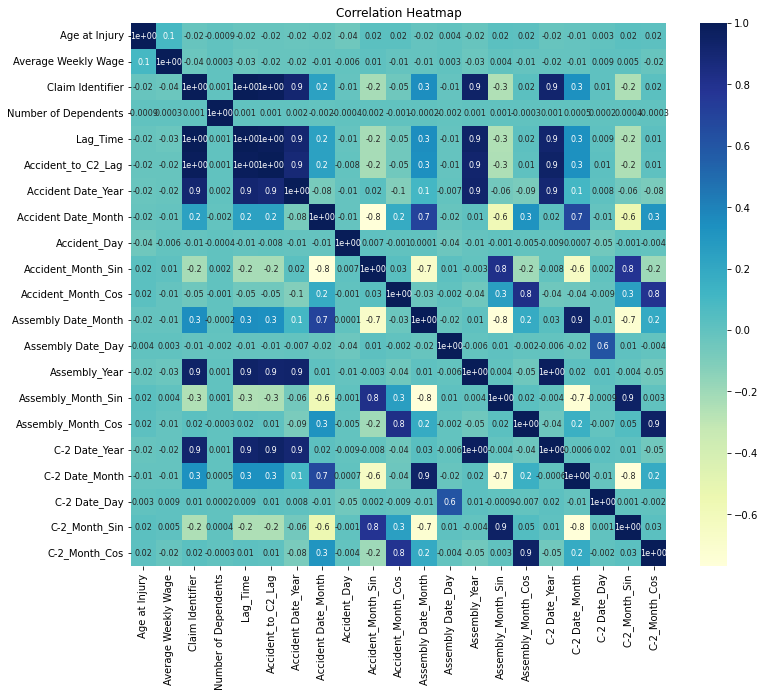

In [32]:
cor_heatmap(X_train_scaled_num)

### 4.2 RFE XGBoost<a id='rfe'></a>
[to the top](#top)


For RFE with XGBoost, we tested multiple feature subsets by selecting a different number of features (from 10 to 14) and evaluated their performance using the F1 Macro Score on the validation set. The optimal number of features was determined based on the __subset that achieved the highest validation F1 Macro Score__.

We chose XGBoost for RFE because it handles non-linear relationships and interactions between features effectively, making it robust and versatile for feature selection tasks. Additionally, we incorporated XGBoost to introduce diversity in the models used for feature selection, complementing other methods and capturing different perspectives on feature importance.

In [33]:
# Number of features to test
nof_list = np.arange(10, 15)            
high_score = 0
# Variable to store the optimum number of features
nof = 0           
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model = LogisticRegression(solver='saga', class_weight='balanced', max_iter=500) #'saga': Scalable to large datasets, supports L1 and L2 regularization.
    
    # Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X=X_train_scaled_num, y=y_train)
    X_val_rfe = rfe.transform(X_val_scaled_num)
    
    # Train the model
    model.fit(X_train_rfe, y_train)
    
    # Calculate F1 macro score on training data
    y_train_pred = model.predict(X_train_rfe)
    train_score = f1_score(y_train, y_train_pred, average='macro')
    train_score_list.append(train_score)
    
    # Calculate F1 macro score on validation data
    y_val_pred = model.predict(X_val_rfe)
    val_score = f1_score(y_val, y_val_pred, average='macro')
    val_score_list.append(val_score)
    
    # Check if current F1 macro score on validation set is the best
    if val_score >= high_score:
        high_score = val_score
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("F1 Macro Score with %d features: %f" % (nof, high_score))

Optimum number of features: 14
F1 Macro Score with %d features: 0.291842


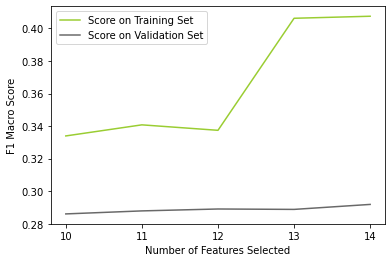

In [66]:
plt.plot(list(range(10,15)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(10,15)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of Features Selected")
plt.ylabel("F1 Macro Score")
plt.xticks(ticks=range(10, 15))
plt.legend()
plt.show()

In [36]:
features_to_select = X_train_scaled_num.columns[rfe.support_]
features_to_select

Index(['Age at Injury', 'Average Weekly Wage', 'Claim Identifier', 'Lag_Time',
       'Accident_to_C2_Lag', 'Accident Date_Year', 'Accident Date_Month',
       'Assembly Date_Month', 'Assembly Date_Day', 'Assembly_Month_Cos',
       'C-2 Date_Month', 'C-2 Date_Day', 'C-2_Month_Sin', 'C-2_Month_Cos'],
      dtype='object')

### 4.3 Random Forest Feature Importance <a id='rf'></a>
[to the top](#top)

Random Forest ranks features based on their contribution to reducing impurity. We use it because it is robust to multicollinearity and captures non-linear relationships, making it well-suited for identifying relevant numerical features in complex datasets.

We use a threshold of __1 / num_features__ to focus on features with above-average importance, ensuring that only the most significant predictors are retained.

In [34]:
# Train a Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled_num, y_train)

# Extract feature importance values
feature_importances = model.feature_importances_

# Calculate the threshold
num_features = X_train_scaled_num.shape[1]
threshold = 1 / num_features

# Get the indices of features to keep
features_to_keep = np.where(feature_importances >= threshold)[0]

# Filter the dataset to keep only selected features
X_train_selected = X_train_scaled_num.iloc[:, features_to_keep]

# Convert selected features back to DataFrame (if needed)
X_train_selected_df = pd.DataFrame(X_train_selected, columns=np.array(X_train_scaled_num.columns)[features_to_keep])

# Print the result
print(f"Number of original features: {num_features}")
print(f"Number of selected features: {len(features_to_keep)}")
print(f"Selected features: {list(X_train_selected_df.columns)}")

Number of original features: 21
Number of selected features: 6
Selected features: ['Age at Injury', 'Average Weekly Wage', 'Claim Identifier', 'Number of Dependents', 'Accident_to_C2_Lag', 'Accident_Day']


### 4.4 Lasso Regression <a id='lr'></a>
[to the top](#top)

Lasso performs feature selection while maintaining predictive accuracy by eliminating irrelevant numerical features. In this approach, our criteria is to retain only features with __coefficients greater than zero__, ensuring that only predictors with a meaningful contribution are included

In [35]:
lasso = LassoCV()
lasso.fit(X_train_scaled_num, y_train)

LassoCV()

In [36]:
coef = pd.Series(lasso.coef_, index = X_train_scaled_num.columns)
coef.sort_values()

Claim Identifier       -0.236909
Accident_Month_Sin     -0.008013
Assembly_Year          -0.006994
C-2_Month_Sin          -0.004813
Accident_Month_Cos     -0.004028
Assembly_Month_Cos      0.000000
Assembly_Month_Sin      0.000000
Assembly Date_Day       0.000000
C-2_Month_Cos          -0.000000
Accident_to_C2_Lag     -0.000000
Lag_Time               -0.000000
Number of Dependents   -0.000000
Accident_Day            0.002757
C-2 Date_Day            0.003037
C-2 Date_Month          0.009797
Accident Date_Month     0.018931
Assembly Date_Month     0.022557
Age at Injury           0.023499
Accident Date_Year      0.069108
C-2 Date_Year           0.121555
Average Weekly Wage     0.823123
dtype: float64

In [37]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

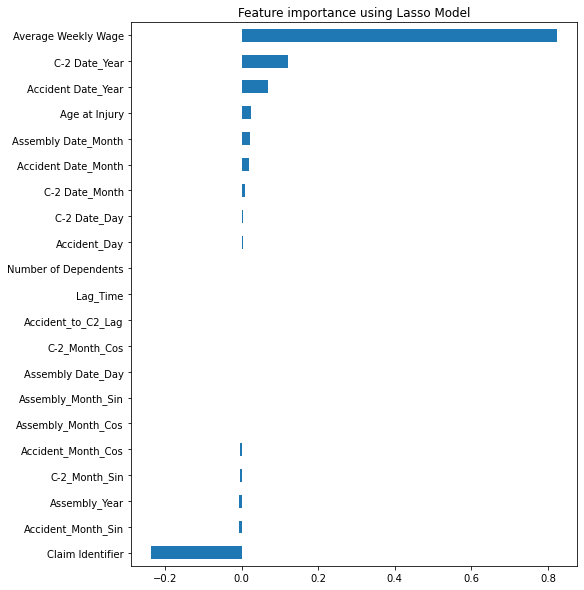

In [38]:
plot_importance(coef,'Lasso')

### 4.5 Chi Square Test <a id='chi'></a>
[to the top](#top)

The Chi-Squared Test evaluates the dependency between categorical variables and the target variable. It is useful for identifying significant categorical predictors.

It determines whether a variable is important based on its p-value compared to a defined alpha threshold (we tested different alpha values). The criteria for a variable to be considered important for prediction if its __p-value is less than the alpha__, indicating a statistically significant dependency between the variable and the target; otherwise, it is discarded.

In [39]:
def TestIndependence(X,y,var,alpha=0.001):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [40]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Age_Group is IMPORTANT for Prediction
Wage_Group is IMPORTANT for Prediction
Medical Fee Region is IMPORTANT for Prediction
Region is IMPORTANT for Prediction
State is IMPORTANT for Prediction
Attorney/Representative is IMPORTANT for Prediction
COVID-19 Indicator is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Carrier Type is IMPORTANT for Prediction
District Name is IMPORTANT for Prediction
Industry Code Description is IMPORTANT for Prediction
County of Injury is IMPORTANT for Prediction
Cause Injury Category is IMPORTANT for Prediction
Nature of Injury Category is IMPORTANT for Prediction
Body Part Category is IMPORTANT for Prediction
Carrier Name Grouped is IMPORTANT for Prediction


Chi-Sqare Test results in all categorical variables are important (even if alpha is very small). That why we use Cramers V as a second method for the importance of the categorical variables.

### 4.6 Cramérs V <a id='c'></a>
[to the top](#top)

Cramér's V is used for categorical variables because it measures the strength of association between two nominal variables, making it ideal for evaluating relationships between categorical predictors and the target variable. Unlike other correlation measures, it works well for data where the variables have no inherent order, providing a normalized value between 0 and 1.

In [41]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

for var in X_train_cat.columns:
    cv = cramers_v(X_train_cat[var], y_train)
    print(f"Cramér's V for {var}: {cv}")

Cramér's V for Age_Group: 0.055398151237964426
Cramér's V for Wage_Group: 0.4455334558152806
Cramér's V for Medical Fee Region: 0.03547905141461885
Cramér's V for Region: 0.02370669060818557
Cramér's V for State: 0.044571734271814
Cramér's V for Attorney/Representative: 0.6136082562137779
Cramér's V for COVID-19 Indicator: 0.1068659760172149
Cramér's V for Gender: 0.06271346506343152
Cramér's V for Carrier Type: 0.07545909529245474
Cramér's V for District Name: 0.041327527954982235
Cramér's V for Industry Code Description: 0.09721000207134345
Cramér's V for County of Injury: 0.05260545848861066
Cramér's V for Cause Injury Category: 0.09117090200130262
Cramér's V for Nature of Injury Category: 0.08091738881104635
Cramér's V for Body Part Category: 0.12868504756816213
Cramér's V for Carrier Name Grouped: 0.11244039566466656


The __threshold of 0.1__ is chosen as a minimum threshold to focus on variables with at least a weak to moderate association with the target, ensuring that only meaningful predictors are retained while discarding those with negligible impact on the model's performance.

In [42]:
threshold = 0.1  # Threshold for Cramer's V
important_vars = [var for var in X_train_cat.columns if cramers_v(X_train_cat[var], y_train) >= threshold]
print("Important Variables:", important_vars)

Important Variables: ['Wage_Group', 'Attorney/Representative', 'COVID-19 Indicator', 'Body Part Category', 'Carrier Name Grouped']


### 4.7 Summary <a id='summary'></a>
[to the top](#top)

Since we have an even number of methods for both numerical and categorical features, we decide to discard the feature if half the methods would keep and half would discard.

### Numerical

| Predictor                | Spearman | RFE XGBoost | Random Forest FI | Lasso | Decision |
|--------------------------|----------|-------------|-------------------|-------|----------|
| Age at Injury            | Keep     | Keep        | Keep              | Keep  | Keep     |
| Average Weekly Wage      | Keep     | Keep        | Keep              | Keep  | Keep     |
| Claim Identifier         | Keep     | Keep        | Keep              | Keep  | Keep     |
| Number of Dependents     | Keep     | Discard     | Keep              | Keep  | Keep     |
| Lag_Time                 | Discard  | Keep        | Discard           | Keep  | Discard  |
| Accident_to_C2_Lag       | Discard  | Keep        | Keep              | Keep  | Keep     |
| Accident Date_Year       | Discard  | Keep        | Discard           | Keep  | Discard  |
| Accident Date_Month      | Keep     | Keep        | Discard           | Keep  | Keep     |
| Accident_Day             | Keep     | Discard     | Keep              | Keep  | Keep     |
| Accident_Month_Sin       | Discard  | Discard     | Discard           | Keep  | Discard  |
| Accident_Month_Cos       | Keep     | Keep        | Discard           | Keep  | Keep     |
| Assembly Date_Month      | Discard  | Keep        | Discard           | Keep  | Discard  |
| Assembly Date_Day        | Keep     | Keep        | Discard           | Keep  | Keep     |
| Assembly_Year            | Discard  | Discard     | Discard           | Keep  | Discard  |
| Assembly_Month_Sin       | Discard  | Discard     | Discard           | Keep  | Discard  |
| Assembly_Month_Cos       | Discard  | Keep        | Discard           | Keep  | Discard  |
| C-2 Date_Year            | Discard  | Discard     | Discard           | Keep  | Discard  |
| C-2 Date_Month           | Discard  | Keep        | Discard           | Keep  | Discard  |
| C-2 Date_Day             | Keep     | Keep        | Discard           | Keep  | Keep     |
| C-2_Month_Sin            | Discard  | Keep        | Discard           | Keep  | Discard  |
| C-2_Month_Cos            | Discard  | Keep        | Discard           | Keep  | Discard  |



### Categoricals

| Predictor                     |Chi-Square|Cramér's V| Decision |
|-------------------------------|----------|----------|----------|
| Age_Group                     | Keep     |Discard   |Discard   |
| Wage_Group                    | Keep     | Keep     | Keep     |
| Medical Fee Region            | Keep     | Discard  | Discard  |
| Region                        | Keep     | Discard  | Discard  |
| State                         | Keep     | Discard  | Discard  |
| Attorney/Representative       | Keep     | Keep     | Keep     |
| COVID-19 Indicator            | Keep     | Keep     | Keep     |
| Gender                        | Keep     | Discard  | Discard  |
| Carrier Type                  | Keep     | Discard  | Discard  |
| District Name                 | Keep     | Discard  | Discard  |
| Industry Code Description     | Keep     | Discard  | Discard  |
| County of Injury              | Keep     | Discard  | Discard  |
| Cause Injury Category         | Keep     | Discard  | Discard  |
| Nature of Injury Category     | Keep     | Discard  | Discard  |
| Body Part Category            | Keep     | Keep     | Keep     |
| Carrier Name Grouped          | Keep     | Keep     | Keep     |


Since we already have "Average Weekly Wage", we decided to not keep the "wage_groups" because it is the same information. For "Attorney/Representative" we will only keep one of the one-hot encoded features, since it only has two classes which results in two perfect correlated variables. The same holds for "COVID-19 Indicator".

In [43]:
# Numerical final features
final_features = [
    "Age at Injury",
    "Average Weekly Wage",
    "Claim Identifier",
    "Number of Dependents",
    "Accident_to_C2_Lag",
    "Accident Date_Month",
    "Accident_Day",
    "Accident_Month_Cos",
    "Assembly Date_Day",
    "C-2 Date_Day",
    "Attorney/Representative_N",
    "COVID-19 Indicator_N"
]

In [44]:
all_columns = X_train_df_scaled.columns

# Finding One-Hot-Encoded-Columns
categorical_features_to_keep = ["Body Part Category", "Carrier Name Grouped"]
encoded_features = [col for col in all_columns if any(var in col for var in categorical_features_to_keep)]

final_features.extend(encoded_features)
len(final_features)

45

In [45]:
X_train_final_features = X_train_df_scaled[final_features]
X_val_final_features = X_val_df_scaled[final_features]
X_test_final_features = X_test_df_scaled[final_features]
X_test_submission_final_features = X_test_submission_df_scaled[final_features]

### 5. Saving Files <a id='save'></a>
[to the top](#top)

In [46]:
output_folder = "model_input_files"
os.makedirs(output_folder, exist_ok=True)

# Save the datasets to CSV files in the folder
X_train_final_features.to_csv(os.path.join(output_folder, "X_train_final_features.csv"), index=False)
X_val_final_features.to_csv(os.path.join(output_folder, "X_val_final_features.csv"), index=False)
X_test_final_features.to_csv(os.path.join(output_folder, "X_test_final_features.csv"), index=False)
X_test_submission_final_features.to_csv(os.path.join(output_folder, "X_test_submission_final_features.csv"), index=False)

print(f"Datasets saved to the folder: {output_folder}")

Datasets saved to the folder: model_input_files
